In [1]:
import pandas as pd
import joblib
import sglearn

from model_predictions import (deepspcas9_predictions, rule_set2_predictions,
                               crispron_predictions,
                               vbc_predictions)
from datasets import behan_data
import target_featurization as ft
from core import (setup_plots,
                  get_model_correlations,
                  get_model_rank_loss,
                  point_range_plot)

In [2]:
setup_plots()

In [3]:
nt_model = joblib.load('../models/RuleSet3.pkl')
target_model = joblib.load('../models/target_model.pkl')
train_data_names = pd.read_csv('../data/processed/train_data_names.csv').name.to_list()
protein_domains = pd.read_csv('../data/interim/protein_domains.csv')
aa_seqs = pd.read_csv('../data/interim/aa_seqs.csv')

In [4]:
dataset_activity_list = []
dataset_list = [behan_data]
for ds in dataset_list:
    if ds.endogenous:
        ds.load_data()
        ds.set_sgrnas()
        dataset_activity = ds.get_sg_df(include_group=True, include_activity=True)
        dataset_activity['dataset'] = ds.name
        dataset_activity['genomewide'] = ds.genomewide
        design_df = ds.get_designs()
        dataset_activity = dataset_activity.merge(design_df, how='inner',
                                                  on=['sgRNA Sequence', 'sgRNA Context Sequence', 'PAM Sequence'])
        dataset_activity_list.append(dataset_activity)
dataset_activity_df = (pd.concat(dataset_activity_list)
                       .reset_index(drop=True))
dataset_activity_df = ft.add_target_columns(dataset_activity_df)  # only necessary for getting transcript bases
dataset_activity_df

,sgRNA Sequence,sgRNA Context Sequence,PAM Sequence,sgRNA Target,sgRNA Activity,dataset,genomewide,Input,Quota,Target Taxon,...,On-Target Rank,Off-Target Rank,On-Target Rank Weight,Off-Target Rank Weight,Combined Rank,Pick Order,Picking Round,Picking Notes,AA Index,Transcript Base
0,AAAAACCTGGTCATGAACAC,ACTGAAAAACCTGGTCATGAACACTGGACC,TGG,RPP40,0.392439,Behan2019,True,ENSG00000124787,MAX,9606,...,22,7,1.0,1.0,5,1.0,1.0,None,62,ENST00000380051
1,AAAAAGATCATGATTGAGCG,ATGTAAAAAGATCATGATTGAGCGGGGAGA,GGG,EIF2B1,0.312222,Behan2019,True,ENSG00000111361,MAX,9606,...,13,2,1.0,1.0,1,1.0,1.0,None,95,ENST00000424014
2,AAAAATAGTTGTAGAGACGC,TCATAAAAATAGTTGTAGAGACGCAGGATG,AGG,AURKB,-0.146409,Behan2019,True,ENSG00000178999,MAX,9606,...,66,72,1.0,1.0,52,NaN,NaN,Cloning Incompatibility ('GAGACG'); Spacing Vi...,139,ENST00000585124
3,AAAAATTGTAGGGCGCACCA,TGCCAAAAATTGTAGGGCGCACCAAGGATG,AGG,NCAPG,0.563045,Behan2019,True,ENSG00000109805,MAX,9606,...,16,24,1.0,1.0,3,1.0,1.0,None,217,ENST00000251496
4,AAAACGGTAATATCGCCGTG,TTTGAAAACGGTAATATCGCCGTGTGGCAG,TGG,GTF3C4,-0.160358,Behan2019,True,ENSG00000125484,MAX,9606,...,2,77,1.0,1.0,9,14.0,2.0,Previously skipped due to: Spacing Violation: ...,286,ENST00000372146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7437,TTTTTCAGTTGTTGTGGTGC,TGGATTTTTCAGTTGTTGTGGTGCTGGGAC,TGG,PSMB7,-1.571472,Behan2019,True,ENSG00000136930,MAX,9606,...,103,82,1.0,1.0,103,NaN,NaN,Spacing Violation: Too close to earlier picks ...,88,ENST00000259457
7438,TTTTTCGAAGTACATGGCCC,CTTCTTTTTCGAAGTACATGGCCCAGGCAC,AGG,LSG1,0.480396,Behan2019,True,ENSG00000041802,MAX,9606,...,109,45,1.0,1.0,47,NaN,NaN,Spacing Violation: Too close to earlier picks ...,226,ENST00000265245
7439,TTTTTCTTCCAGAAAAATCC,TTCTTTTTTCTTCCAGAAAAATCCTGGGTA,TGG,TMEM41B,-0.373971,Behan2019,True,ENSG00000166471,MAX,9606,...,53,48,1.0,1.0,54,NaN,NaN,Spacing Violation: Too close to earlier picks ...,42,ENST00000611268
7440,TTTTTGCACTAGCCTGAATA,TATTTTTTTGCACTAGCCTGAATAGGGCTA,GGG,BORA,-0.597036,Behan2019,True,ENSG00000136122,MAX,9606,...,115,5,1.0,1.0,42,NaN,NaN,Spacing Violation: Too close to earlier pick a...,314,ENST00000377815


In [5]:
transcript_bases = list(dataset_activity_df['Transcript Base']
                        .unique())
conservation_df = (pd.read_parquet('../data/interim/conservation.parquet',
                                   filters=[[('Transcript Base', 'in', transcript_bases)]])
                   .reset_index(drop=True))

## Get Predictions

### External Models

In [6]:
model_prediction_list = [deepspcas9_predictions,
                         rule_set2_predictions,
                         vbc_predictions,
                         crispron_predictions]
for model_prediction in model_prediction_list:
    model_prediction.load_model_predictions()
    model_prediction.set_sgrnas()
    if model_prediction.target_col is None:
        dataset_activity_df = dataset_activity_df.merge(model_prediction.prediction_df,
                                                        how='left',
                                                        on=['sgRNA Sequence',
                                                            'sgRNA Context Sequence',
                                                            'PAM Sequence'])
    else:
        dataset_activity_df = dataset_activity_df.merge(model_prediction.prediction_df,
                                                        how='left',
                                                        left_on=['sgRNA Sequence',
                                                                 'sgRNA Context Sequence',
                                                                 'PAM Sequence',
                                                                 'sgRNA Target'],
                                                        right_on=['sgRNA Sequence',
                                                                  'sgRNA Context Sequence',
                                                                  'PAM Sequence',
                                                                  model_prediction.target_col])
    dataset_activity_df[model_prediction.name + ' train'] = (dataset_activity_df['sgRNA Sequence']
                                                             .isin(model_prediction.sgrnas))
dataset_activity_df

,sgRNA Sequence,sgRNA Context Sequence,PAM Sequence,sgRNA Target,sgRNA Activity,dataset,genomewide,Input,Quota,Target Taxon,...,Rule Set 2,Rule Set 2 train,gene,VBC score,VBC Activity,VBC Bioscore,genome,VBC score train,CRISPRon,CRISPRon train
0,AAAAACCTGGTCATGAACAC,ACTGAAAAACCTGGTCATGAACACTGGACC,TGG,RPP40,0.392439,Behan2019,True,ENSG00000124787,MAX,9606,...,0.568884,False,RPP40,0.587,0.574,0.455,hg38,False,43.54,False
1,AAAAAGATCATGATTGAGCG,ATGTAAAAAGATCATGATTGAGCGGGGAGA,GGG,EIF2B1,0.312222,Behan2019,True,ENSG00000111361,MAX,9606,...,0.669325,False,EIF2B1,0.701,0.589,0.694,hg38,False,22.93,False
2,AAAAATAGTTGTAGAGACGC,TCATAAAAATAGTTGTAGAGACGCAGGATG,AGG,AURKB,-0.146409,Behan2019,True,ENSG00000178999,MAX,9606,...,0.552263,False,NaN,NaN,NaN,NaN,NaN,True,34.11,False
3,AAAAATTGTAGGGCGCACCA,TGCCAAAAATTGTAGGGCGCACCAAGGATG,AGG,NCAPG,0.563045,Behan2019,True,ENSG00000109805,MAX,9606,...,0.654583,False,NCAPG,0.703,0.800,0.542,hg38,False,50.16,False
4,AAAACGGTAATATCGCCGTG,TTTGAAAACGGTAATATCGCCGTGTGGCAG,TGG,GTF3C4,-0.160358,Behan2019,True,ENSG00000125484,MAX,9606,...,0.746170,False,GTF3C4,0.729,0.814,0.551,hg38,False,45.26,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7491,TTTTTCAGTTGTTGTGGTGC,TGGATTTTTCAGTTGTTGTGGTGCTGGGAC,TGG,PSMB7,-1.571472,Behan2019,True,ENSG00000136930,MAX,9606,...,0.305635,False,PSMB7,0.376,-0.007,0.588,hg38,False,11.40,False
7492,TTTTTCGAAGTACATGGCCC,CTTCTTTTTCGAAGTACATGGCCCAGGCAC,AGG,LSG1,0.480396,Behan2019,True,ENSG00000041802,MAX,9606,...,0.522798,False,LSG1,0.558,0.517,0.497,hg38,False,38.33,False
7493,TTTTTCTTCCAGAAAAATCC,TTCTTTTTTCTTCCAGAAAAATCCTGGGTA,TGG,TMEM41B,-0.373971,Behan2019,True,ENSG00000166471,MAX,9606,...,0.406823,False,TMEM41B,0.508,0.318,0.515,hg38,False,2.66,False
7494,TTTTTGCACTAGCCTGAATA,TATTTTTTTGCACTAGCCTGAATAGGGCTA,GGG,BORA,-0.597036,Behan2019,True,ENSG00000136122,MAX,9606,...,0.456245,False,BORA,0.520,0.383,0.525,hg38,False,8.82,False


In [7]:
model_prediction_names = [m.name for m in model_prediction_list]
dataset_activity_df[model_prediction_names].isna().sum()

DeepSpCas9      0
Rule Set 2      0
VBC score     715
CRISPRon        0
dtype: int64

### Rule Set 3

In [8]:
train_data_list = list()
for ds in dataset_list:
    if ds.name in train_data_names:
        train_data_list.append(ds)

train_data_sgs = set()
for ds in train_data_list:
    ds.load_data()
    ds.set_sgrnas()
    train_data_sgs |= set(ds.sgrnas)

X = sglearn.featurize_guides(dataset_activity_df['sgRNA Context Sequence'])
dataset_activity_df['Rule Set 3'] = nt_model.predict(X)
dataset_activity_df['Rule Set 3 train'] = dataset_activity_df['sgRNA Sequence'].isin(train_data_sgs)
dataset_activity_df

,sgRNA Sequence,sgRNA Context Sequence,PAM Sequence,sgRNA Target,sgRNA Activity,dataset,genomewide,Input,Quota,Target Taxon,...,gene,VBC score,VBC Activity,VBC Bioscore,genome,VBC score train,CRISPRon,CRISPRon train,Rule Set 3,Rule Set 3 train
0,AAAAACCTGGTCATGAACAC,ACTGAAAAACCTGGTCATGAACACTGGACC,TGG,RPP40,0.392439,Behan2019,True,ENSG00000124787,MAX,9606,...,RPP40,0.587,0.574,0.455,hg38,False,43.54,False,-0.105120,False
1,AAAAAGATCATGATTGAGCG,ATGTAAAAAGATCATGATTGAGCGGGGAGA,GGG,EIF2B1,0.312222,Behan2019,True,ENSG00000111361,MAX,9606,...,EIF2B1,0.701,0.589,0.694,hg38,False,22.93,False,-0.082529,False
2,AAAAATAGTTGTAGAGACGC,TCATAAAAATAGTTGTAGAGACGCAGGATG,AGG,AURKB,-0.146409,Behan2019,True,ENSG00000178999,MAX,9606,...,NaN,NaN,NaN,NaN,NaN,True,34.11,False,-0.148542,False
3,AAAAATTGTAGGGCGCACCA,TGCCAAAAATTGTAGGGCGCACCAAGGATG,AGG,NCAPG,0.563045,Behan2019,True,ENSG00000109805,MAX,9606,...,NCAPG,0.703,0.800,0.542,hg38,False,50.16,False,0.311628,False
4,AAAACGGTAATATCGCCGTG,TTTGAAAACGGTAATATCGCCGTGTGGCAG,TGG,GTF3C4,-0.160358,Behan2019,True,ENSG00000125484,MAX,9606,...,GTF3C4,0.729,0.814,0.551,hg38,False,45.26,False,0.570242,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7491,TTTTTCAGTTGTTGTGGTGC,TGGATTTTTCAGTTGTTGTGGTGCTGGGAC,TGG,PSMB7,-1.571472,Behan2019,True,ENSG00000136930,MAX,9606,...,PSMB7,0.376,-0.007,0.588,hg38,False,11.40,False,-1.390447,False
7492,TTTTTCGAAGTACATGGCCC,CTTCTTTTTCGAAGTACATGGCCCAGGCAC,AGG,LSG1,0.480396,Behan2019,True,ENSG00000041802,MAX,9606,...,LSG1,0.558,0.517,0.497,hg38,False,38.33,False,-0.557408,False
7493,TTTTTCTTCCAGAAAAATCC,TTCTTTTTTCTTCCAGAAAAATCCTGGGTA,TGG,TMEM41B,-0.373971,Behan2019,True,ENSG00000166471,MAX,9606,...,TMEM41B,0.508,0.318,0.515,hg38,False,2.66,False,-1.876164,False
7494,TTTTTGCACTAGCCTGAATA,TATTTTTTTGCACTAGCCTGAATAGGGCTA,GGG,BORA,-0.597036,Behan2019,True,ENSG00000136122,MAX,9606,...,BORA,0.520,0.383,0.525,hg38,False,8.82,False,-1.407939,False


### Rule Set 3 Target

In [9]:
target_cols = ['sgRNA Sequence', 'sgRNA Context Sequence',
               'Orientation', 'Target Cut %', 'Target Cut Length',
               'Target Transcript']  # Note don't need Transcript Base and AA Index
unique_activity = dataset_activity_df[target_cols].drop_duplicates()
target_feature_df, target_feature_cols = ft.build_target_feature_df(unique_activity,
                                                                    features=['position', 'aa',
                                                                              'domain'],
                                                                    aa_seq_df=aa_seqs,
                                                                    protein_domain_df=protein_domains,
                                                                    conservation_df=conservation_df)
X_target = target_feature_df[target_feature_cols]
unique_activity['Target Score'] = target_model.predict(X_target)
dataset_activity_df = (dataset_activity_df.merge(unique_activity, how='left',
                                                 on=target_cols))
dataset_activity_df['Rule Set 3 Target'] = (dataset_activity_df['Rule Set 3'] +
                                            dataset_activity_df['Target Score'])
dataset_activity_df['Rule Set 3 Target train'] = dataset_activity_df['Rule Set 3 train']

### Performance

In [10]:
score_cols = ['Rule Set 3', 'Rule Set 3 Target'] + model_prediction_names
guide_train_cols = [name + ' train' for name in score_cols]
filtered_predictions = dataset_activity_df[~dataset_activity_df[guide_train_cols].any(axis=1)].copy()
long_predictions = (filtered_predictions.melt(id_vars=['sgRNA Sequence', 'sgRNA Context Sequence',
                                                       'PAM Sequence', 'sgRNA Activity',
                                                       'sgRNA Target', 'dataset', 'genomewide'],
                                              value_vars=score_cols,
                                              var_name='model',
                                              value_name='prediction')
                    .dropna())

In [11]:
cor_performance_ci = get_model_correlations(long_predictions)

100%|██████████| 1000/1000 [00:54<00:00, 18.25it/s]


/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 3 x 2.5 in image.
/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../figures/target_rs3_performance_alt_tracr.pdf


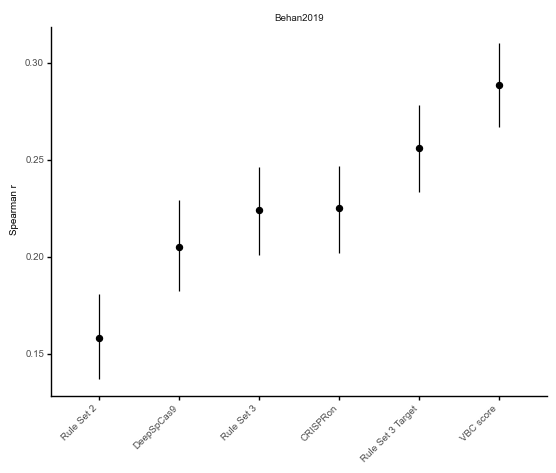

<ggplot: (8761433357969)>

In [12]:
g = point_range_plot(cor_performance_ci, 'model', 'spearman',
                     'spearman_025', 'spearman_975', xlabel='',
                     ylabel='Spearman r', wspace=0.4)
g.save('../figures/target_rs3_performance_alt_tracr.pdf', width=3, height=2.5)
g

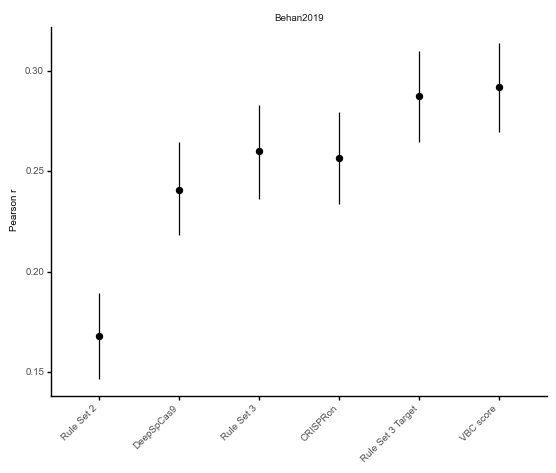

<ggplot: (8761448506612)>

In [13]:
point_range_plot(cor_performance_ci, 'model', 'pearson',
                 'pearson_025', 'pearson_975', xlabel='',
                 ylabel='Pearson r')

In [14]:
genomewide_predictions = long_predictions[long_predictions.genomewide].copy()
rank_loss_performance_ci = get_model_rank_loss(genomewide_predictions)

100%|██████████| 1000/1000 [01:03<00:00, 15.84it/s]


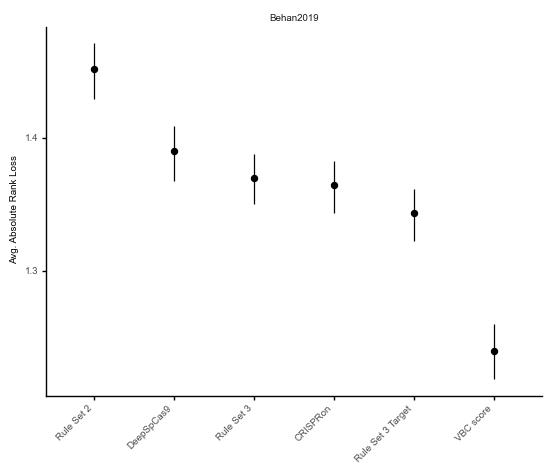

<ggplot: (8761412588310)>

In [15]:
g = point_range_plot(rank_loss_performance_ci, 'model', 'avg_abs_rank_diff',
                     'avg_abs_rank_diff_025', 'avg_abs_rank_diff_975', xlabel='',
                     ylabel='Avg. Absolute Rank Loss', wspace=0.4)
g